In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install elephas
!pip install pyngrok==4.1.1
!apt install openjdk-8-jdk-headless --yes



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 9.3 MB/s 
     |████████████████████████████████| 281.3 MB 38 kB/s 
     |████████████████████████████████| 198 kB 49.5 MB/s 
  Created wheel for elephas: filename=elephas-3.1.0-py3-none-any.whl size=26259 sha256=8dbfae779627478d212724b0570b3a874c7281b84eb1a2c20c20a332f124e907
  Stored in directory: /root/.cache/pip/wheels/33/e4/e1/56dda8be927bb0e9971cd7ddf3fc1b17ce78db56268b1f867f
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805911 sha256=8ad8f94573f87e558a3c467d30c170153d1dd07fa0e8519fc94e24594e8b6b0c
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built elephas pyspark
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
Looking in indexes: htt

In [3]:
#imports
import io
import os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import numpy as np
import matplotlib.pyplot as plt
from pyngrok import ngrok
from zipfile import ZipFile
#pyspark
import pyspark
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.types import StructType,StructField,ArrayType,StringType,LongType,BinaryType,IntegerType,FloatType
from pyspark import SparkContext, SparkConf
# Elephas for Deep Learning on Spark
from elephas.ml_model import ElephasEstimator, ElephasTransformer,load_ml_transformer
from elephas.utils.model_utils import ModelType, argmax
#Keras Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array
from keras .models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers, regularizers

plt.rcParams["figure.figsize"] = (8,5.5)


In [4]:
with ZipFile('/content/drive/MyDrive/Big_data_data/plant_data_v1.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('unzip_plant')
   print('File is unzipped in temp folder') 

File is unzipped in temp folder


In [5]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.driver.memory', '100G').set('spark.driver.maxResultSize', '100G')
# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "32")

In [7]:
selected_plants=['Apple','Cherry','Corn','Grape','Peach','Pepper','Potato','Strawberry','Tomato']
rootdir_test='/content/unzip_plant/New Plant Diseases Dataset(Augmented)/valid'

In [8]:
import pickle 
file = open("/content/inal_label_to_disease_2_june_v4",'rb')
get_label = pickle.load(file) 

In [9]:
get_label
get_label_reversed = {v: k for k, v in get_label.items()}

In [10]:
image_h=24
image_w=24
channels=3
#create empty datframe
emptyRDD = spark.sparkContext.emptyRDD()
schema =StructType([
        StructField('content',BinaryType(),True),
        StructField('label',IntegerType(),True)
    ])
images_df = spark.createDataFrame(emptyRDD,schema)

#import data
for it in os.scandir(rootdir_test):
    class_plant=os.path.basename(os.path.normpath(it.path))
    if it.is_dir() and class_plant.startswith(tuple(selected_plants)):
        print("Adding Class into Data Frame ------->",class_plant)
        single_df=spark.read.format("BinaryFile").load(it.path).withColumn("label", lit(get_label[class_plant]))
        single_df=single_df.select('content','label')
        images_df=images_df.union(single_df)
        single_df.unpersist(blocking=True)

def featurizer(content):
    imm=img_to_array((Image.open(io.BytesIO(content)).resize([image_h,image_w])),dtype='float16')/255
    return imm.flatten().tolist()

convertUDF = udf(lambda z: featurizer(z), ArrayType(FloatType()))
images_df=images_df.repartition(16).select(convertUDF("content").alias("features"),col("label"))

list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
images_df = images_df.select(
col("label"),list_to_vector_udf(images_df["features"]).alias("features"))

Adding Class into Data Frame -------> Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Adding Class into Data Frame -------> Strawberry___Leaf_scorch
Adding Class into Data Frame -------> Pepper,_bell___Bacterial_spot
Adding Class into Data Frame -------> Peach___healthy
Adding Class into Data Frame -------> Tomato___Early_blight
Adding Class into Data Frame -------> Apple___Black_rot
Adding Class into Data Frame -------> Apple___Cedar_apple_rust
Adding Class into Data Frame -------> Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Adding Class into Data Frame -------> Tomato___Bacterial_spot
Adding Class into Data Frame -------> Potato___healthy
Adding Class into Data Frame -------> Tomato___Late_blight
Adding Class into Data Frame -------> Grape___Esca_(Black_Measles)
Adding Class into Data Frame -------> Corn_(maize)___Common_rust_
Adding Class into Data Frame -------> Corn_(maize)___Northern_Leaf_Blight
Adding Class into Data Frame -------> Tomato___Tomato_Yellow_Leaf_Curl_Virus
Adding

In [11]:
# Number of rows : 15231
# images_df.count()

15231

## Testing on unseen data

*   Load the trained Elephas transformer 
*   Predict on testing set


*   Use MulticlassClassificationEvaluator from pyspark to calculate metrics for each class and put them in dataframe
*   Convert labels and prediction from pyspark dataframe to numpy arrays and use scikit-learn to calculate and plot confusion matrix.







In [12]:
loaded_transformer = load_ml_transformer('/content/colab_elephas_transformer_2june_v4.h5')

In [13]:
pred=loaded_transformer.transform(images_df)

In [14]:
from pyspark.sql.types import DoubleType
pred = pred.drop("features")
pred = pred.select(col('label').astype(DoubleType()), argmax('prediction').astype(DoubleType()).alias('prediction')).cache()
evaluator = MulticlassClassificationEvaluator()
evaluator.setPredictionCol("prediction")
accuracy=evaluator.evaluate(pred)

In [15]:
falsePositiveRate=[]
recall=[]
precision=[]
for i in range(len(get_label)):
  falsePositiveRate.append((evaluator.evaluate(pred, {evaluator.metricName: "falsePositiveRateByLabel",
    evaluator.metricLabel: float(i)})))
  recall.append((evaluator.evaluate(pred, {evaluator.metricName: "recallByLabel",
    evaluator.metricLabel: float(i)})))
  precision.append((evaluator.evaluate(pred, {evaluator.metricName: "precisionByLabel",
    evaluator.metricLabel: float(i)})))
  


In [16]:
import pandas 
dic={'falsePositiveRate':falsePositiveRate,'recall':recall,'precision':precision}
class_report_df=pandas.DataFrame(dic)
class_report_df=class_report_df.rename(index=get_label_reversed)
class_report_df['f1_score'] = 2*(class_report_df.precision*class_report_df.recall)/(class_report_df.precision+class_report_df.recall)
class_report_df.loc['average']=class_report_df.mean(axis=0)
class_report_df.loc['accuracy']=accuracy
class_report_df.to_csv('Big_data_eval_v4.csv')

In [17]:
class_report_df

,falsePositiveRate,recall,precision,f1_score
Tomato___Target_Spot,0.004264,0.857768,0.861538,0.859649
Tomato___Tomato_mosaic_virus,0.001826,0.986607,0.942431,0.964013
Tomato___Early_blight,0.005898,0.810417,0.817227,0.813808
Corn_(maize)___Common_rust_,0.000610,0.989518,0.981289,0.985386
Tomato___Bacterial_spot,0.002094,0.934118,0.927570,0.930832
Corn_(maize)___Northern_Leaf_Blight,0.003592,0.945493,0.894841,0.919470
"Pepper,_bell___Bacterial_spot",0.005016,0.916318,0.855469,0.884848
Apple___Cedar_apple_rust,0.001961,0.909091,0.932401,0.920598
Tomato___Spider_mites Two-spotted_spider_mite,0.003177,0.912644,0.894144,0.903299
Apple___Black_rot,0.002104,0.933602,0.937374,0.935484


In [19]:
label=np.array(pred.select('label').collect())
prediction=np.array(pred.select('prediction').collect())

In [20]:
def mp(entry):
    return get_label_reversed[entry] if entry in get_label_reversed else entry
mp = np.vectorize(mp)
label=mp(label)
prediction=mp(prediction)

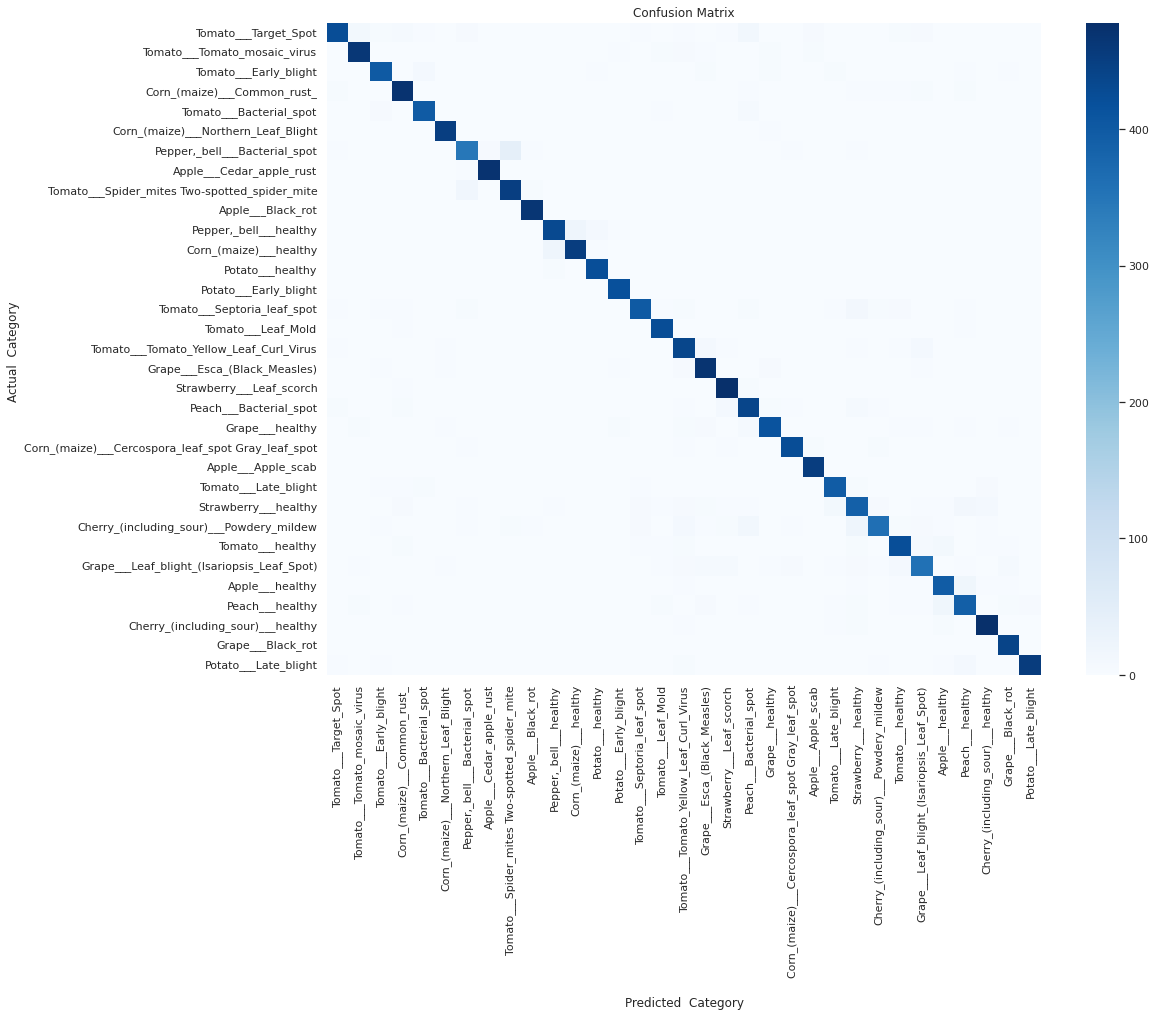

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(rc={'figure.figsize':(16,12)})


confusion_mat=confusion_matrix(label,prediction)

ax = sns.heatmap(confusion_mat, cmap='Blues')
ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted  Category')
ax.set_ylabel('Actual  Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(get_label.keys(),rotation = 90)
ax.yaxis.set_ticklabels(get_label.keys(),rotation = 0)

## Display the visualization of the Confusion Matrix.
plt.savefig('cm-2j-v4.png')
plt.show()